# Deep Deterministic Policy Gradients (DDPG)

In this notebook we explore a neural network based implementation of the Actor-Critic method for Reinforcement Learning. This algorithm can be seen as the convergence of the breakthroughs that came from the DQN paper with the actor-critic algorithm. This algorithm, DDPG, applies the concepts of experience replay using a replay buffer to mitigate the sequential nature of the data being sampled by interaction with the environment, and instead learns by sampling a batch of random samples of experience saved in the replay buffer for gradient based optimization. 

In general, actor-critic algorithms comprise of two parts, an actor and a critic. Both of these parts are learned from data in the form of multilayer perceptrons rather than manual mappings or hand engineered features. The actor here is our policy network. Given an observation as input, the actor picks out the best action possible based on its weights. Since our actor directly picks out a singular action instead of a probability of actions, we say this follows the "deterministic" policy gradients algorithm, thus the "deterministic" in DDPG. The critic, on the other hand, is used to provide feedback to the actor. The critic network predicts the expected value of a state action pair (action picked out by the actor network), which is what is our actor's goal to maximize.

We use the concept of a target network (as in DQN, refer to /reinforcement_learning/DQN for more) in order to stabilize the learning process. 

DDPG was designed to work well in continuous action spaces, so we run our experiences on the mujoco Half-Cheetah-v4 environment that provides us with a "half" cheetah as an agent whose goal is to travel as much in the forward direction as possible. 

In [19]:
import  gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np  

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from IPython.display import clear_output

In [20]:
env = gym.make('HalfCheetah-v4', render_mode = "human")
env.reset()
env.render()

### Action Space
As mentioned previously, the DDPG algorithm shines in continuous action spaces. Our cheetah has 6 pivots upon which it can execute forces from the -1.0 to 1.0 range, as seen below. 

In [21]:
env.action_space

Box(-1.0, 1.0, (6,), float32)

In [22]:
DIM_ACTIONS = 6

### Exploring the observation space 

In [23]:
observation_space = env.observation_space
observation_space

Box(-inf, inf, (17,), float64)

We have a 17 dimensional observation space. Our observations consist of positional values of the different pivots on the cheetah, their velocities and angular velocities with respect to our different euclidean coordinate frames. 

In [24]:
DIM_OBSERVATIONS = 17

### Building a class for our replay buffer
Nothing changes here v/s the DQN implementation 

In [25]:
#named tuple to store experience 
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

#Experience replay buffer object 
class ReplayMemory(object):

    def __init__(self, capacity):
        #contains a deque of specified buffer length 
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        #add new transition to buffer 
        self.memory.append(Transition(*args))

    #simple function to sample some experience from memory randomly 
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Defining our Critic (Q-Value function)
The differences between this network and the Deep Q Network used for pure DQN are: 
- We're now evaluating a single action that has already been selected by the actor so the first linear layer accepts our observation concatenated with our action 
- Since we're evaluating only one action, we output the value estimate for that singluar action only instead of the set of possible actions giving our network an output dimension of 1 

In [26]:
class critic_Q(nn.Module):

    def __init__(self, len_observation_space, dim_actions):
        super(critic_Q, self).__init__()
        #observations to 128 
        self.layer1 = nn.Linear(len_observation_space + dim_actions, 128)
        #linear transformation 
        self.layer2 = nn.Linear(128, 128)
        #linear downsizing to number of possible actions 
        self.layer3 = nn.Linear(128, 1)

    def forward(self, observation, action):
        x = torch.cat([observation, action], dim=-1)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

### Actor Network 
A multilayer perceptron that accepts our observation as input and outputs a deterministic action to be taken at timestep t 

In [27]:
class actor_Policy(nn.Module): 
    def __init__(self, len_observation_space, dim_actions):
        super(actor_Policy, self).__init__()
        #observations to 128 
        self.layer1 = nn.Linear(len_observation_space, 128)
        #linear transformation 
        self.layer2 = nn.Linear(128, 128)
        #deterministically outputting a single action 
        self.layer3 = nn.Linear(128, dim_actions) #output has the specified dimensionality to specify actions with respect to 
                                                  #all action dimensions (in the case of our example, this is 6)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return torch.tanh(self.layer3(x))

### Optimization Function Overview

The following function represents the optimization steps. If our replay buffer is at capacity, we:

- Sample a batch of transitions from memory. This initial step involves drawing a selection of varied transitions from our repository of stored experiences.

- Compute the expected value using the policy network. This step requires us to determine probable outcomes and their associated probabilities, based on our current policy.

- Compute target values by adding the observed reward to the expected next state value. This expected next state value is calculated using the target network instead of the policy network. 

- Compute the loss between the predicted and target values and then optimize the policy network. This final step is crucial for improving the predictive accuracy of our model. It works by learning from the discrepancies between predicted and actual outcomes, and uses these insights to refine the model.

Through this sequence of steps, the function continuously enhances the model's predictive performance by learning from past errors.


In [28]:
def optimize_model(gamma, batch_size, memory, actor, critic, target_actor, target_critic, loss_fn, actor_optimizer, critic_optimizer, device):
    
    if len(memory) < batch_size:
        return
    
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions)) #batches our data as follows: ((state1, state2, ..), (action1, action2, ...), ...)
    
    non_final_mask = torch.tensor([s is not None for s in batch.next_state],
                                  device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    states = torch.cat(batch.state)
    actions = torch.cat(batch.action)
    rewards = torch.cat(batch.reward)
    
    predicted_values = critic(states, actions) 
    
    with torch.no_grad():
        next_actions = target_actor(non_final_next_states)  
    
    next_state_values = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_critic(non_final_next_states, next_actions).squeeze(1)  
    
    target_values = (next_state_values * gamma) +rewards # if the state is non terminal, we add to it the expected value of the next state 
    td_error = target_values - predicted_values 
    
    loss = loss_fn(predicted_values, target_values.unsqueeze(1))
    critic_optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(critic.parameters(), 100)
    critic_optimizer.step()

    log_action = torch.log(actions)
    actor_loss = -critic(states,actor(states)).mean()
    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()

In [29]:
def trainer(num_episodes, batch_size, target_actor, actor, target_critic, critic, gamma, device, replay_buffer, actor_optimizer, critic_optimizer, tau): 
    
    reward_per_episode = []

    for episode in range(num_episodes): 
        
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device = device).unsqueeze(0)
        episode_end = False
        step = 0 
        cum_reward = 0

        while not episode_end:
            
            action = actor(state).squeeze().cpu().detach().numpy()
            noise = np.random.normal(0, 0.1, size=env.action_space.shape) # Adjust the scale (0.1) as needed
            
            action = np.clip(action + noise, env.action_space.low, env.action_space.high)
            next_state, reward, terminated, truncated, _ = env.step(action)
            
            step+=1
            cum_reward+=reward
            
            episode_end = terminated or truncated 
            
            if not terminated: 
                next_state = torch.tensor(next_state, dtype=torch.float32, \
                    device = device).unsqueeze(0) #we only care about next_state if the state is non terminal
            else: 
                next_state = None
            
            action = torch.tensor(action, dtype=torch.int64, device=device).unsqueeze(0)
            reward = torch.tensor(reward, dtype=torch.float32, device=device).unsqueeze(0)

            replay_buffer.push(state, action, next_state, reward)
            state = next_state
            
            optimize_model(gamma, batch_size, replay_buffer, actor, critic, target_actor, target_critic,loss_fn=torch.nn.MSELoss(size_average=True), actor_optimizer=actor_optimizer,\
                           critic_optimizer= critic_optimizer, device=device)
            
            if not episode % (num_episodes / 50) and episode > 0:
                #extract network parameters for both networks 
                target_critic_state_dict = target_critic.state_dict()
                critic_state_dict = critic.state_dict()

                target_actor_state_dict = target_actor.state_dict()
                actor_state_dict = actor.state_dict()
                
                for key in actor_state_dict.keys():
                    # θ′ ← τ θ + (1 −τ )θ′

                    target_actor_state_dict[key] = actor_state_dict[key]*tau + target_actor_state_dict[key]*(1-tau)
                    target_actor.load_state_dict(target_actor_state_dict)
                
                for key in critic_state_dict.keys():    
                    target_critic_state_dict[key] = critic_state_dict[key]*tau + target_critic_state_dict[key]*(1-tau)
                    target_critic.load_state_dict(target_critic_state_dict)
            
        print("Episode: {} Score: {}".format(episode, cum_reward))
        reward_per_episode.append(cum_reward)
        clear_output(wait=True) # Clear the output of the current cell receiving output
        plt.plot(reward_per_episode)
        plt.title('Cumulative Reward per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Cumulative Reward')
        plt.show()

In [30]:
#hyperparams 
NUM_EPISODES = 500 # this is abitrary 
E = 0.5 #we start off with a relatively high exploration rate and then decay that over training steps to start exploiting more 
GAMMA = 1 #
ALPHA = 3e-4
BATCH_SIZE = 32 #we want a relatively large batch size to leverage GPU parallelism but at the same time we want this number to be far 
                #smaller than our memory capacity so that we can sample randomly at the same time 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
replay_buffer = ReplayMemory(100000)

actor = actor_Policy(len_observation_space=DIM_OBSERVATIONS, dim_actions=DIM_ACTIONS)
target_actor = actor_Policy(len_observation_space=DIM_OBSERVATIONS, dim_actions=DIM_ACTIONS)

critic = critic_Q(len_observation_space=DIM_OBSERVATIONS, dim_actions=DIM_ACTIONS)
target_critic = critic_Q(len_observation_space=DIM_OBSERVATIONS, dim_actions=DIM_ACTIONS)

actor.to(DEVICE)
target_actor.to(DEVICE)

critic.to(DEVICE)
target_critic.to(DEVICE)

target_actor.load_state_dict(actor.state_dict())
target_critic.load_state_dict(critic.state_dict())

<All keys matched successfully>

In [32]:
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=ALPHA)

In [33]:
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=ALPHA)

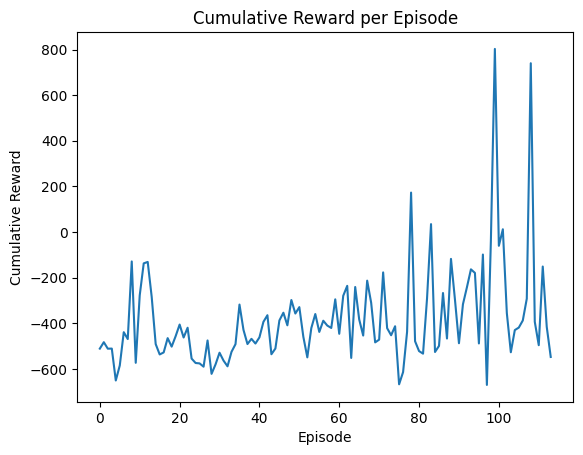

In [34]:
trainer(num_episodes=NUM_EPISODES, batch_size=BATCH_SIZE, actor=actor, critic=critic, target_actor=target_actor, target_critic=target_critic,\
         gamma=GAMMA, device=DEVICE, replay_buffer=replay_buffer, actor_optimizer=actor_optimizer, critic_optimizer=critic_optimizer, tau=0.005)